# Getting the data 

In [4]:
%%capture
pip install git+https://github.com/source-separation/tutorial

In [6]:
%%capture
from common import data, viz
import nussl
import numpy as np
# Prepare MUSDB
data.prepare_musdb('~/.nussl/tutorial/')

ImportError: Numba needs NumPy 1.22 or less

Initialize Scaper object and wrap it in a nussl OnTheFly dataset

In [ ]:
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

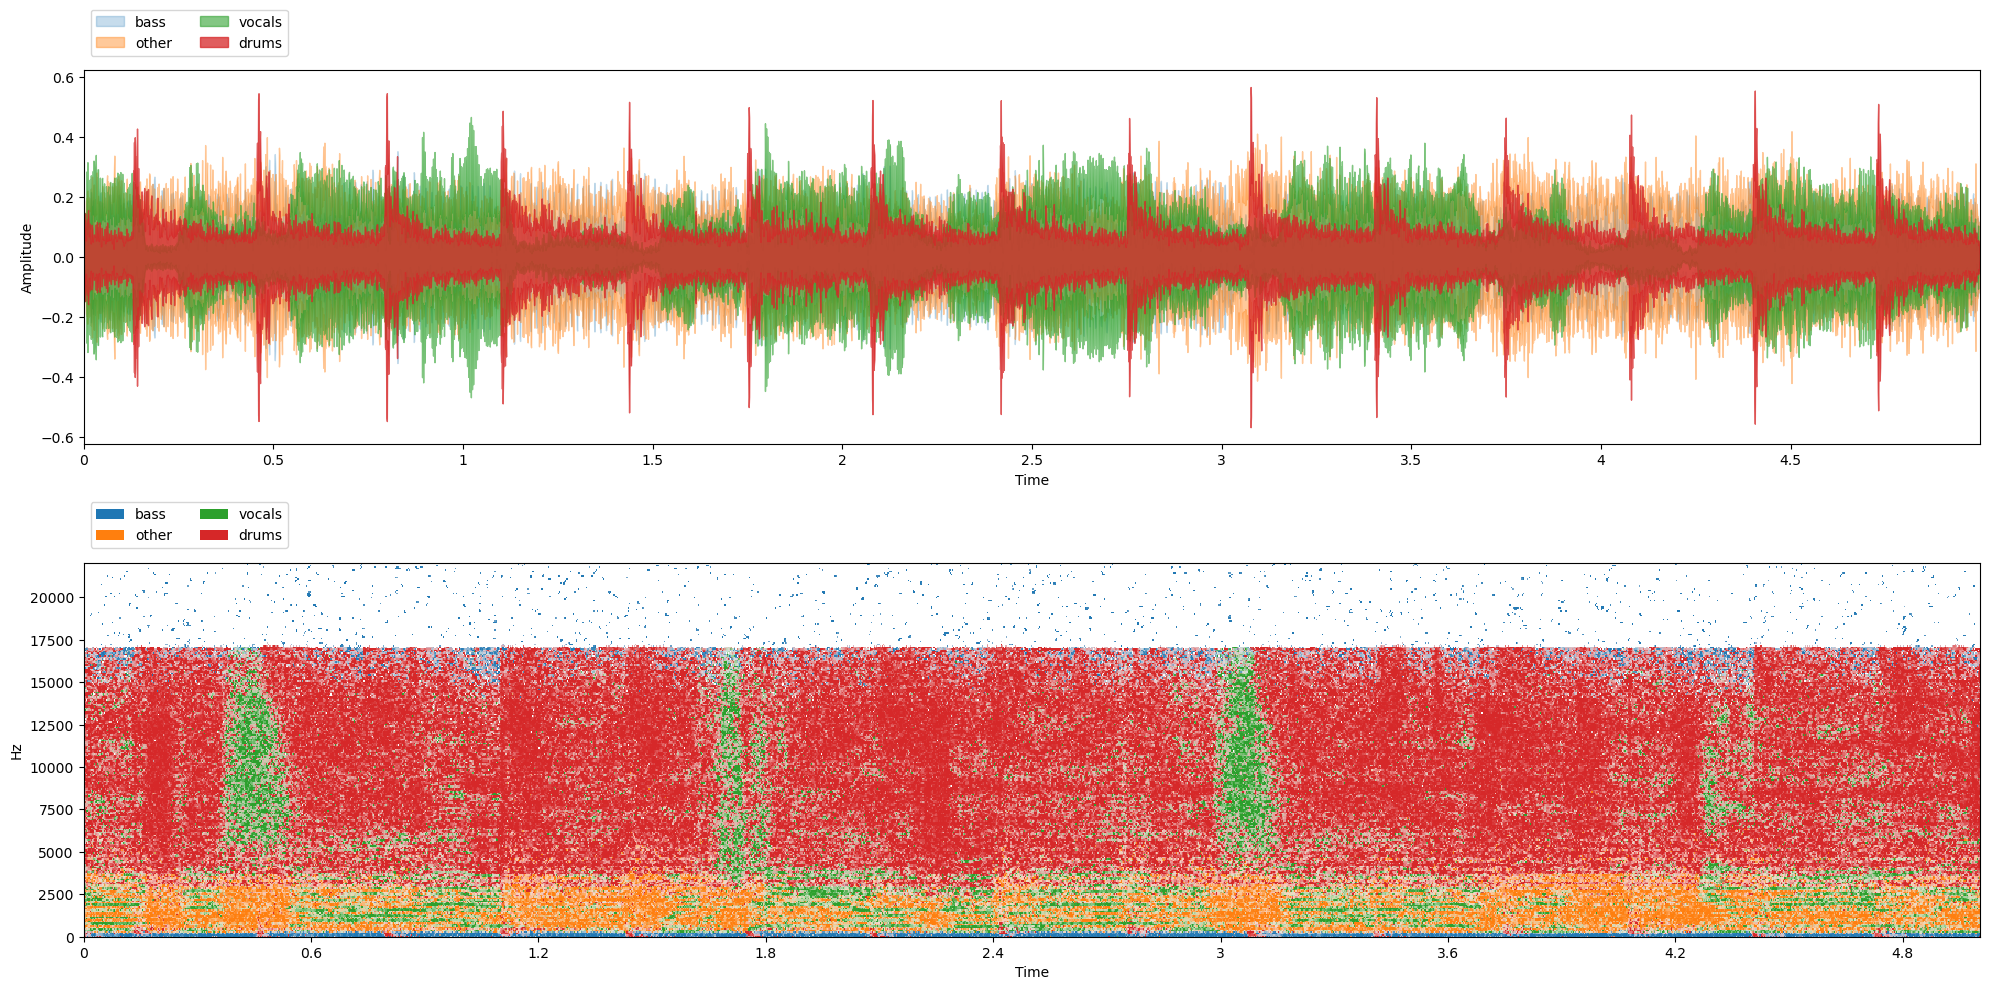


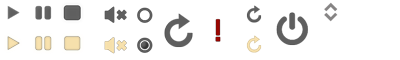
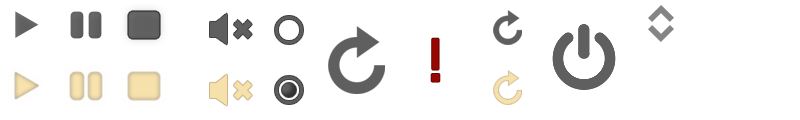
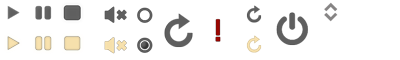

In [ ]:
item = train_data[0]
viz.show_sources(item['sources'])

### Make Validation and test datasets

In [ ]:
fg_path = "~/.nussl/tutorial/valid"
val_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=500)

fg_path = "~/.nussl/tutorial/test"
test_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=100)

### Feeding our data into our model 

Each item from this dataset is structured as a dictionary with the following keys:
- mix: An audioSignal object with the mixture of all the sources
- sources: A dictionary where keys are source labels, and the values are corresponding 
- metadata: Metadata for the item - comtains the corresponding JAMS file for the generated mixture 

## Data Transforms

Transforms:

- SumSources: combines the selected sources into a single source. Use it to combine drum, bass, and other sources into a single accompaniment sourcves, whoch will be helpful for evaluating the models performance 

- MagnitudeSpectrumApproximation: computes the spectrograms of the targets and the spectrogram of the mixture. The first is used for our loss and the second is used as input to the model

- IndexSources: for the output of the model, we only care about the estimate of the vocals, so we'll use this transform to discard the other targte spectrograms

- ToSeperationModel: converts all of the values in the dictionary to Tensors so they can be fed to our model 

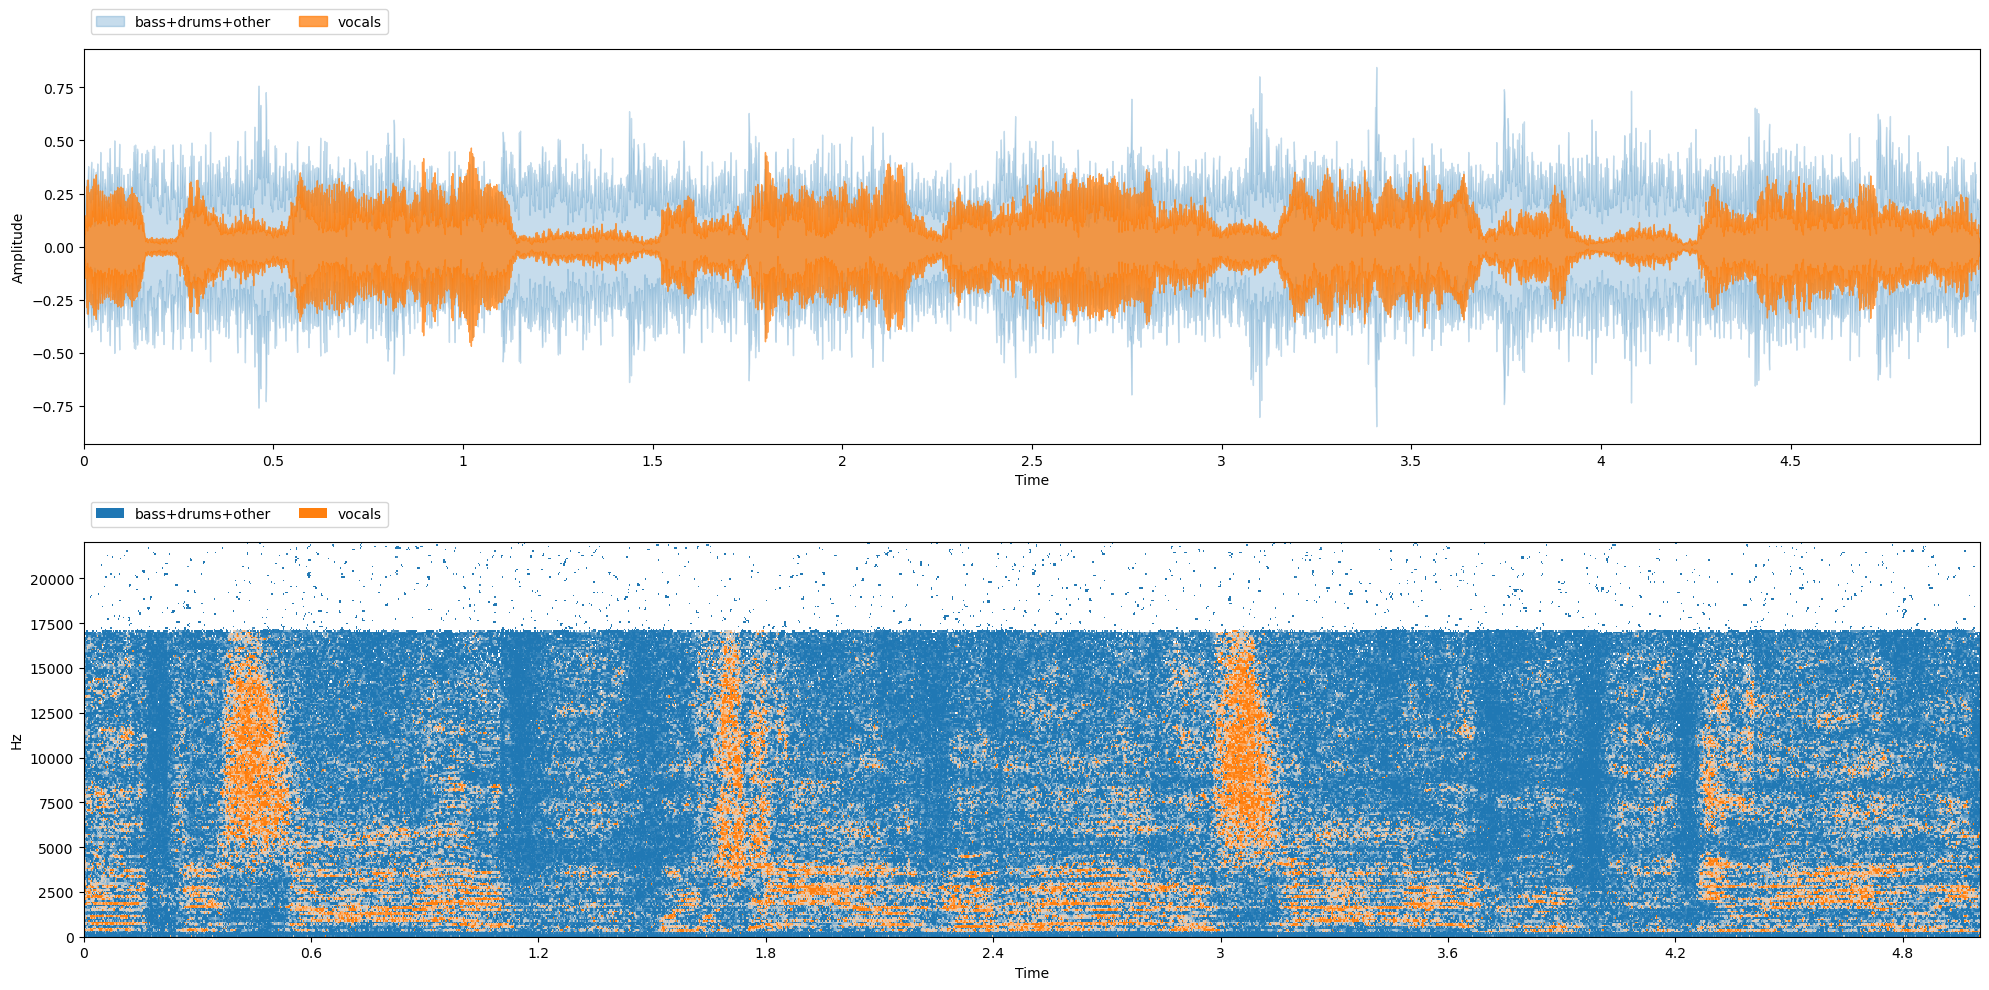


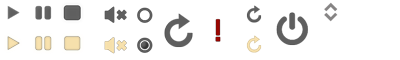
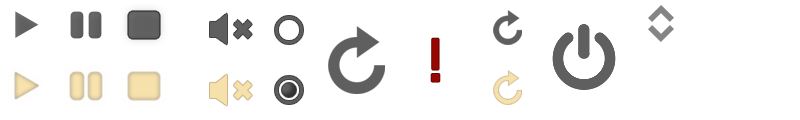
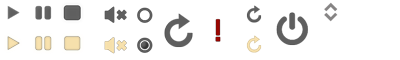

In [ ]:
from nussl.datasets import transforms as nussl_tfm

item = train_data[0]
sum_sources = nussl_tfm.SumSources([['bass', 'drums', 'other']])
item = sum_sources(item)
viz.show_sources(item['sources'])

In [ ]:
msa = nussl_tfm.MagnitudeSpectrumApproximation()
item = msa(item)

dict_keys(['mix', 'sources', 'metadata', 'mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])


Three new keys added:

- mix_magnitude: The magnitude spectrogram of the mixture, as a numpy array
- source_magnitudes: The magnitude spectrogram of each source, as a numpy array
- ideal_binary_mask: the ideal binary mask for each source

Dimensions of each are:

- Number of frequency bins in STFT
- Number of time steps in STFT
- Number of audio Channels 
- Number of sources - only for source_magnitudes and ideal_binary_mask

The input to our model will be the data in item['mixm_magnitude'] and the targets will be from item['source_magnitudes']

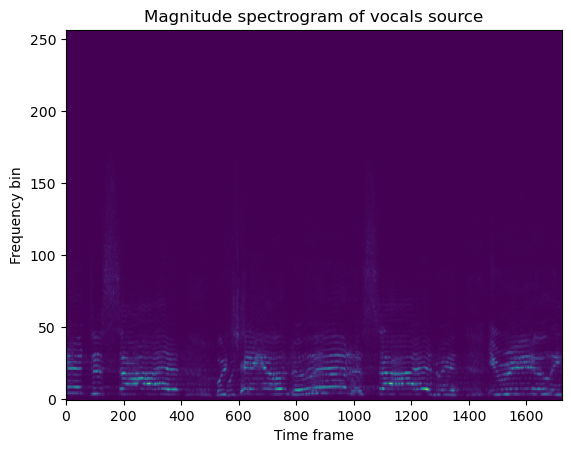

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(item['source_magnitudes'][..., 1][..., 0], aspect='auto', origin='lower')
plt.title('Magnitude spectrogram of vocals source')
plt.xlabel('Time frame')
plt.ylabel('Frequency bin')
plt.show()

In [ ]:
index_sources = nussl_tfm.IndexSources('source_magnitudes', 1)
item = index_sources(item)

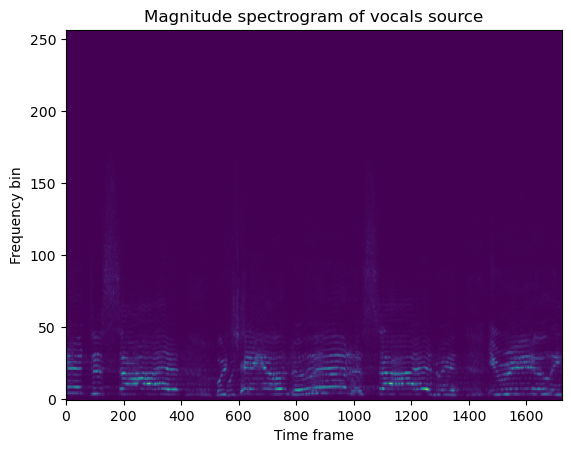

(257, 1724, 1, 1) (257, 1724, 1) (257, 1724, 1, 2)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(item['source_magnitudes'][..., 0, 0], aspect='auto', origin='lower')
plt.title('Magnitude spectrogram of vocals source')
plt.xlabel('Time frame')
plt.ylabel('Frequency bin')
plt.show()

print(item['source_magnitudes'].shape, item['mix_magnitude'].shape, item['ideal_binary_mask'].shape)

Converting the data dictionary to pytorch tensors and excluding anything that is incompatible with pytorch tensors. 

In [ ]:
to_separation_model = nussl_tfm.ToSeparationModel()
item = to_separation_model(item)

In [ ]:
for key in item: 
    print (key, type(item[key]), item[key].shape)

mix_magnitude <class 'torch.Tensor'> torch.Size([1724, 257, 1])
ideal_binary_mask <class 'torch.Tensor'> torch.Size([1724, 257, 1, 2])
source_magnitudes <class 'torch.Tensor'> torch.Size([1724, 257, 1, 1])


Put them all togather in a final transform

In [ ]:
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

item = train_data[0]
print("Before transforms")
for key in item:
    print(key, type(item[key]))
print("\nAfter transforms")
item = tfm(item)
for key in item:
    print(key, type(item[key]))

Before transforms
mix <class 'nussl.core.audio_signal.AudioSignal'>
sources <class 'dict'>
metadata <class 'dict'>

After transforms
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


Initialize the mixer with these transformations so they happen everytime we draw an item from the dataset

In [ ]:
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=tfm, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

item = train_data[0]
print("Item from train data")
for key in item:
    print(key, type(item[key]))

fg_path = "~/.nussl/tutorial/valid"
val_data = data.on_the_fly(stft_params, transform=tfm, fg_path=fg_path, num_mixtures=500)

test_tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])

fg_path = "~/.nussl/tutorial/test"
test_data = data.on_the_fly(stft_params, transform=test_tfm, fg_path=fg_path, num_mixtures=100)

Item from train data
index <class 'int'>
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


# Building the model

A reccurrent mask inference model

In [ ]:
from nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding
from torch import nn
import torch

class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        
        output = {
            'mask': mask,
            'estimates': estimates
        }
        return output

nussl has a special class - nussl.ml.SeparationModel which all models must integrate with. This is for ease of deployment. The model code above is not yet built how nussl expects. Integrating a model with nussl is an easy three-step process:

1. Register your model code with nussl via nussl.ml.register_module.

2. Build a configuration function for your model that defines the inputs and outputs.

3. Instantiate your model via the output of the configuration function.

Convert the model into a SeparationModel that is compatible with nussl by adding a class method

In [ ]:
import os
import json

import torch
from torch import nn
import numpy as np


class SeparationModel(nn.Module):
    """
    SeparationModel takes a configuration file or dictionary that describes the model
    structure, which is some combination of MelProjection, Embedding, RecurrentStack,
    ConvolutionalStack, and other modules found in ``nussl.ml.networks.modules``. 

    References:
        Hershey, J. R., Chen, Z., Le Roux, J., & Watanabe, S. (2016, March).
        Deep clustering: Discriminative embeddings for segmentation and separation.
        In Acoustics, Speech and Signal Processing (ICASSP),
        2016 IEEE International Conference on (pp. 31-35). IEEE.

        Luo, Y., Chen, Z., Hershey, J. R., Le Roux, J., & Mesgarani, N. (2017, March).
        Deep clustering and conventional networks for music separation: Stronger together.
        In Acoustics, Speech and Signal Processing (ICASSP),
        2017 IEEE International Conference on (pp. 61-65). IEEE.

    Args:
        config: (str, dict) Either a config dictionary that defines the model and its
          connections, or the path to a json file containing the dictionary. If the
          latter, the path will be loaded and used.

    See also:
        ml.register_module to register your custom modules with SeparationModel.

    Examples:
        >>> config = nussl.ml.networks.builders.build_recurrent_dpcl(
        >>>     num_features=512, hidden_size=300, num_layers=3, bidirectional=True,
        >>>     dropout=0.3, embedding_size=20, 
        >>>     embedding_activation=['sigmoid', 'unit_norm'])
        >>>
        >>> model = SeparationModel(config)
    """
    def __init__(self, config, verbose=False):
        super(SeparationModel, self).__init__()
        if type(config) is str:
            if os.path.exists(config):
                with open(config, 'r') as f:
                    config = json.load(f)
            else:
                config = json.loads(config)

        self._validate_config(config)

        module_dict = {}
        self.input = {}
        for module_key in config['modules']:
            module = config['modules'][module_key]
            if 'class' in module:
                if module['class'] in dir(modules): 
                    class_func = getattr(modules, module['class'])
                else:
                    class_func = getattr(nn, module['class'])
                if 'args' not in module:
                    module['args'] = {}
                module_dict[module_key] = class_func(**module['args'])
            else:
                self.input[module_key] = module_key

        self.layers = nn.ModuleDict(module_dict)
        self.connections = config['connections']
        self.output_keys = config['output']
        self.config = config
        self.verbose = verbose

    @staticmethod
    def _validate_config(config):
        expected_keys = ['connections', 'modules', 'output']
        got_keys = sorted(list(config.keys()))

        if got_keys != expected_keys:
            raise ValueError(
                f"Expected keys {expected_keys}, got {got_keys}")

        if not isinstance(config['modules'], dict):
            raise ValueError("config['modules'] must be a dict!")

        if not isinstance(config['connections'], list):
            raise ValueError("config['connections'] must be a list!")

        if not isinstance(config['output'], list):
            raise ValueError("config['output'] must be a list!")

    def forward(self, data):
        """
        Args:
            data: (dict) a dictionary containing the input data for the model. 
            Should match the input_keys in self.input.

        Returns:

        """
        if not all(name in list(data) for name in list(self.input)):
            raise ValueError(
                f'Not all keys present in data! Needs {", ".join(self.input)}')
        output = {}

        for connection in self.connections:
            layer = self.layers[connection[0]]
            input_data = []
            kwargs = {}

            if len(connection) == 2:
                for c in connection[1]:
                    if isinstance(c, dict):
                        for key, val in c.items():
                            if val in output:
                                kwargs[key] = output[val]
                            elif val in data:
                                kwargs[key] = data[val]
                            else:
                                kwargs[key] = val
                    else:
                        input_data.append(output[c] if c in output else data[c])
            _output = layer(*input_data, **kwargs)
            added_keys = []
            if isinstance(_output, dict):
                for k in _output:
                    _key = f'{connection[0]}:{k}'
                    output[_key] = _output[k]
                    added_keys.append(_key)
            elif isinstance(_output, tuple):
                for i, val in enumerate(_output):
                    _key = f'{connection[0]}:{i}'
                    output[_key] = val
                    added_keys.append(_key)
            else:
                _key = connection[0]
                output[_key] = _output
                added_keys.append(_key)
            
            if self.verbose:
                input_shapes = []
                for d in input_data:
                    if torch.is_tensor(d):
                        input_shapes.append(d.shape)
                input_desc = ", ".join(map(str, input_shapes))
                output_desc = ", ".join(
                    [f'{k}: {output[k].shape}' for k in added_keys])
                print(
                    f"{connection[1]} -> {connection[0]} \n"
                    f"\tTook inputs: {input_desc} \n"
                    f"\tProduced {output_desc} "
                )
                
        return {o: output[o] for o in self.output_keys}


    
    def save(self, location, metadata=None):
        """
        Saves a SeparationModel into a location into a dictionary with the
        weights and model configuration.
        Args:
            location: (str) Where you want the model saved, as a path.

        Returns:
            (str): where the model was saved.

        """
        save_dict = {
            'state_dict': self.state_dict(),
            'config': json.dumps(self.config)
        }

        metadata = metadata if metadata else {}
        metadata['nussl_version'] = __version__
        save_dict = {**save_dict, **metadata}
        torch.save(save_dict, location)
        return location

    
    def __repr__(self):
        output = super().__repr__()
        num_parameters = 0
        for p in self.parameters():
            if p.requires_grad:
                num_parameters += np.cumprod(p.size())[-1]
        output += '\nNumber of parameters: %d' % num_parameters
        return output



In [ ]:
from nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding, separation_model
from nussl.ml import SeparationModel
from torch import nn
import torch

class MaskInference(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        
        output = {
            'mask': mask,
            'estimates': estimates
        }
        return output
    
    # Added function
    @classmethod
    def build(cls, num_features, num_audio_channels, hidden_size, 
              num_layers, bidirectional, dropout, num_sources, 
              activation='sigmoid'):
        # Step 1. Register our model with nussl
        nussl.ml.register_module(cls)
        
        # Step 2a: Define the building blocks.
        modules = {
            'model': {
                'class': 'MaskInference',
                'args': {
                    'num_features': num_features,
                    'num_audio_channels': num_audio_channels,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'bidirectional': bidirectional,
                    'dropout': dropout,
                    'num_sources': num_sources,
                    'activation': activation
                }
            }
        }
        
        # Step 2b: Define the connections between input and output.
        # Here, the mix_magnitude key is the only input to the model.
        connections = [
            ['model', ['mix_magnitude']]
        ]
        
        # Step 2c. The model outputs a dictionary, which SeparationModel will
        # change the keys to model:mask, model:estimates. The lines below 
        # alias model:mask to just mask, and model:estimates to estimates.
        # This will be important later when we actually deploy our model.
        for key in ['mask', 'estimates']:
            modules[key] = {'class': 'Alias'}
            connections.append([key, f'model:{key}'])
        
        # Step 2d. There are two outputs from our SeparationModel: estimates and mask.
        # Then put it all together.
        output = ['estimates', 'mask',]
        config = {
            'name': cls.__name__,
            'modules': modules,
            'connections': connections,
            'output': output
        }
        # Step 3. Instantiate the model as a SeparationModel.
        return nussl.ml.SeparationModel(config)

nf = stft_params.window_length // 2 + 1
nac = 1
model = MaskInference.build(nf, nac, 50, 2, True, 0.3, 1, 'sigmoid')

ImportError: cannot import name 'separation_model' from 'nussl.ml.networks.modules' (/opt/miniconda3/envs/tf/lib/python3.10/site-packages/nussl/ml/networks/modules/__init__.py)

In [ ]:
from common.models import MaskInference
nf = stft_params.window_length // 2+1
nac = 1
model = MaskInference.build(nf, nac, 50, 2, True, 0.3, 1, 'sigmoid')

Now that we’ve got a model, let’s feed an item from our dataset into it. To do this:

1. Add a batch dimension by unsqueezing along the 0th axis.

2. Cast the item to a float, the way PyTorch expects it.



In [ ]:
item = train_data[0]
for key in item:
    if torch.is_tensor(item[key]):
        item[key] = item[key].float().unsqueeze(0)
output = model(item)